# Sarcasm Detection with Bidirectional LSTM

`@author Haemin Choi`
* two types of word embeddings were used
  - GloVe (pre-trained)
  - Word2vec (not pre-trained)

### 1. Loading Sarcasm Dataset and Preprocessing

In [ ]:
import json
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from bs4 import BeautifulSoup
import string
import tensorflow as tf
import numpy as np

In [ ]:
stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at",
             "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do",
             "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having",
             "he", "hed", "hes", "her", "here", "heres", "hers", "herself", "him", "himself", "his", "how",
             "hows", "i", "id", "ill", "im", "ive", "if", "in", "into", "is", "it", "its", "itself",
             "lets", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought",
             "our", "ours", "ourselves", "out", "over", "own", "same", "she", "shed", "shell", "shes", "should",
             "so", "some", "such", "than", "that", "thats", "the", "their", "theirs", "them", "themselves", "then",
             "there", "theres", "these", "they", "theyd", "theyll", "theyre", "theyve", "this", "those", "through",
             "to", "too", "under", "until", "up", "very", "was", "we", "wed", "well", "were", "weve", "were",
             "what", "whats", "when", "whens", "where", "wheres", "which", "while", "who", "whos", "whom", "why",
             "whys", "with", "would", "you", "youd", "youll", "youre", "youve", "your", "yours", "yourself",
             "yourselves"]

table = str.maketrans('', '', string.punctuation)

In [ ]:
len(stopwords)

151

In [ ]:
with open("sarcasm.json", 'r') as f:
  datastore = json.load(f)

sentences = []
labels = []
urls = []
for item in datastore:
    sentence = item['headline'].lower()
    sentence = sentence.replace(",", " , ")
    sentence = sentence.replace(".", " . ")
    sentence = sentence.replace("-", " - ")
    sentence = sentence.replace("/", " / ")
    soup = BeautifulSoup(sentence)
    sentence = soup.get_text()
    words = sentence.split()
    filtered_sentence = ""
    for word in words:
        word = word.translate(table)
        if word not in stopwords:
            filtered_sentence = filtered_sentence + word + " "
    sentences.append(filtered_sentence)
    labels.append(item['is_sarcastic'])
    urls.append(item['article_link'])

<ipython-input-4-cae21d9a6990>:13: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(sentence)


In [ ]:
vocab_size = 13200 # number of words that corresponds with the ones in GloVe embedding
embedding_dim = 25
max_length = 50
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 23000

In [ ]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [ ]:
tokenizer = Tokenizer(oov_token=oov_tok, num_words=vocab_size)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length,
                                padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length,
                               padding=padding_type, truncating=trunc_type)

In [ ]:
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

### 2-1. Using Pre-trained GloVe Word Embedding
- pre-trained with 27 billion tokens and 1.2 million words collected from twitter
- embedding dimensions: 25(used in this experiment), 50, 100, 200

In [ ]:
# download GloVe file
! wget https://bit.ly/3i9taLA -O glove.zip

--2024-04-24 13:37:29--  https://bit.ly/3i9taLA
Resolving bit.ly (bit.ly)... 67.199.248.11, 67.199.248.10
Connecting to bit.ly (bit.ly)|67.199.248.11|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://tensorflowkorea.files.wordpress.com/2022/03/glove.twitter.27b.25d.txt.zip [following]
--2024-04-24 13:37:29--  https://tensorflowkorea.files.wordpress.com/2022/03/glove.twitter.27b.25d.txt.zip
Resolving tensorflowkorea.files.wordpress.com (tensorflowkorea.files.wordpress.com)... 192.0.72.19, 192.0.72.18
Connecting to tensorflowkorea.files.wordpress.com (tensorflowkorea.files.wordpress.com)|192.0.72.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109906941 (105M) [application/zip]
Saving to: ‘glove.zip’

glove.zip           100%[===================>] 104.81M  79.0MB/s    in 1.3s    

2024-04-24 13:37:30 (79.0 MB/s) - ‘glove.zip’ saved [109906941/109906941]



In [ ]:
# unzip the file
import os
import zipfile
local_zip = 'glove.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('glove')
zip_ref.close()

In [ ]:
# create a dictionary with words for key and embedding vectors for value

glove_embeddings = dict()
f = open('glove/glove.twitter.27B.25d.txt')
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  glove_embeddings[word] = coefs
f.close()

In [ ]:
glove_embeddings['great']

array([-8.4229e-01,  3.6512e-01, -3.8841e-01, -4.6118e-01,  2.4301e-01,
        3.2412e-01,  1.9009e+00, -2.2630e-01, -3.1335e-01, -1.0970e+00,
       -4.1494e-03,  6.2074e-01, -5.0964e+00,  6.7418e-01,  5.0080e-01,
       -6.2119e-01,  5.1765e-01, -4.4122e-01, -1.4364e-01,  1.9130e-01,
       -7.4608e-01, -2.5903e-01, -7.8010e-01,  1.1030e-01, -2.7928e-01],
      dtype=float32)

In [ ]:
# check out how many words from our dataset corresponds with the ones in GloVe embedding

xs = [] # index
ys = [] # 1 if the word is in the embedding else 0
cumulative_y = []
total_y = 0

for word, index in tokenizer.word_index.items():
  xs.append(index)
  if glove_embeddings.get(word) is not None:
    total_y = total_y + 1
    ys.append(1)
  else:
    ys.append(0)
  cumulative_y.append(total_y / index)

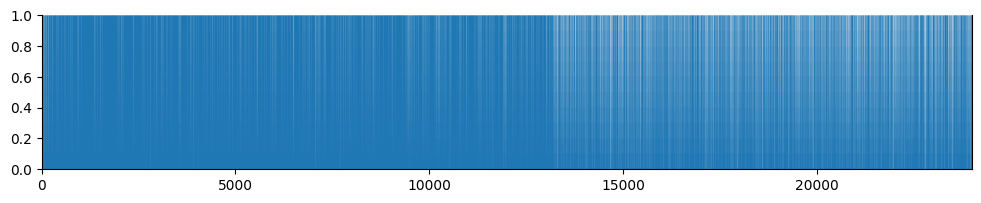

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,2))
ax.spines['top'].set_visible(False)

plt.margins(x=0, y=None, tight=True)
plt.axis([0, 24000, 0, 1])
plt.fill(ys)
plt.show()

# we can see that about 13,000 tokens corresponds with the ones in the embedding
# thus vocabuluary size = 13,200

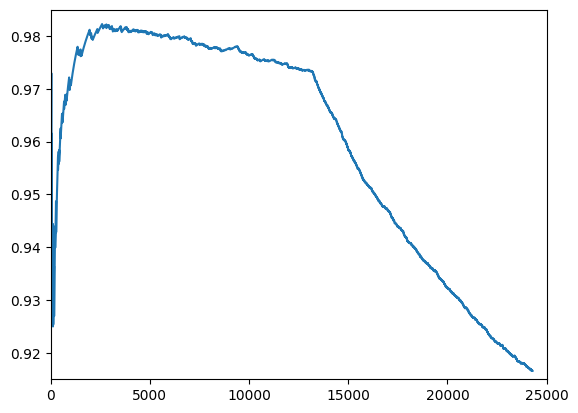

In [ ]:
plt.plot(xs, cumulative_y)
plt.axis([0, 25000, .915, .985])
plt.show()

In [ ]:
# create an embedding matrix using pre-trained Glove word vectors

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, index in tokenizer.word_index.items():
    if index > vocab_size - 1:
        break
    else:
        embedding_vector = glove_embeddings.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

In [ ]:
# building neural network with pre-trained GloVe word embedding
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              weights=[embedding_matrix], trainable=False), # trainable must be set FALSE since it does not need to be trained
    # LSTM
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

adam = tf.keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999,
                                amsgrad=False)
model.compile(loss='binary_crossentropy',optimizer=adam,metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 25)          330000    
                                                                 
 bidirectional (Bidirection  (None, None, 50)          10200     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 50)                15200     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 24)                1224      
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 356649 (1.36 MB)
Trainable params: 26649 (

In [ ]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs,
                    validation_data=(testing_padded, testing_labels))

Epoch 1/30
719/719 [==============================] - 25s 24ms/step - loss: 0.6897 - accuracy: 0.5541 - precision_2: 0.4516 - recall_2: 0.0585 - val_loss: 0.6852 - val_accuracy: 0.5700 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 2/30
719/719 [==============================] - 17s 23ms/step - loss: 0.6835 - accuracy: 0.5599 - precision_2: 1.0000 - recall_2: 5.9236e-04 - val_loss: 0.6784 - val_accuracy: 0.5697 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 3/30
719/719 [==============================] - 12s 17ms/step - loss: 0.6667 - accuracy: 0.5848 - precision_2: 0.7222 - recall_2: 0.0929 - val_loss: 0.6502 - val_accuracy: 0.6363 - val_precision_2: 0.6358 - val_recall_2: 0.3611
Epoch 4/30
719/719 [==============================] - 12s 17ms/step - loss: 0.6366 - accuracy: 0.6512 - precision_2: 0.6326 - recall_2: 0.4960 - val_loss: 0.6375 - val_accuracy: 0.6387 - val_precision_2: 0.5817 - val_recall_2: 0.5693
Epoch 5/30
719/719 [========================

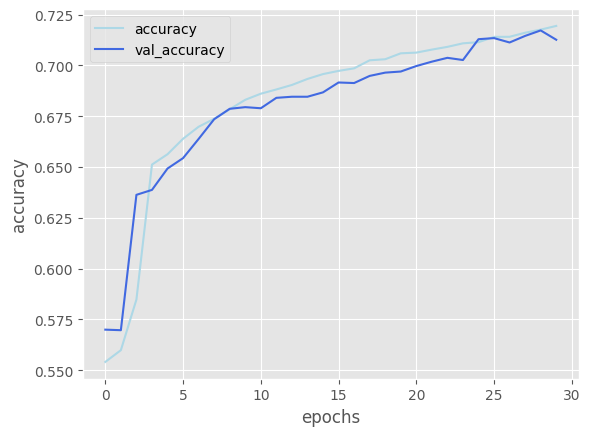

In [ ]:
# visualisation of training and validation accuracy
plt.style.use('ggplot')
plt.plot(history.history['accuracy'], color='lightblue')
plt.plot(history.history['val_accuracy'], color='royalblue')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

# validation accuracy is close to training accuracy -> overfitting prevented

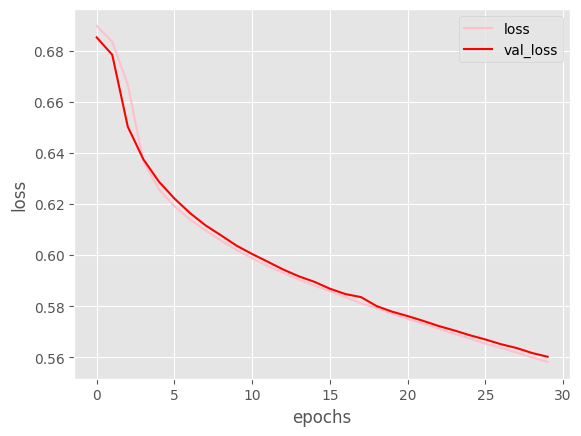

In [ ]:
# visualisation of training and validation loss
plt.plot(history.history['loss'], color='pink')
plt.plot(history.history['val_loss'], color='red')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

# validation loss is close to training loss -> overfitting prevented

In [ ]:
# performance score
accuracy = history.history['val_accuracy'][-1]
recall = history.history['val_recall_2'][-1]
precision = history.history['val_precision_2'][-1]
f1score = (2*precision*recall) / (precision+recall)

print("Accuracy: {}".format(accuracy))
print("Recall: {}".format(recall))
print("Precision: {}".format(precision))
print("F1 Score: {}".format(f1score))

Accuracy: 0.7125909924507141
Recall: 0.6012539267539978
Precision: 0.6904247403144836
F1 Score: 0.642761387682164


### 2-2. Using Word2vec Embedding
- create a word embedding with tokens from our dataset on Word2Vec algorithm
- train LSTM with the word embedding

In [ ]:
words = []
for i in range(len(sentences)):
  words.append(sentences[i].split())

In [ ]:
words[3]

['boehner',
 'just',
 'wants',
 'wife',
 'listen',
 'not',
 'come',
 'alternative',
 'debt',
 'reduction',
 'ideas']

In [ ]:
import gensim

embed_dim = 25

# creating word vectors by word2vec method
word2vec_model = gensim.models.Word2Vec(vector_size=25, sentences = words, window=5, min_count=1)

In [ ]:
word2vec_model.wv['nice']

array([ 0.01304085,  0.0036489 ,  0.13180375, -0.37131602,  0.01084068,
       -0.2351346 ,  0.3142342 ,  0.4467869 , -0.30493474, -0.34155023,
        0.07738504,  0.03127333,  0.07968355,  0.12851676, -0.49701965,
        0.2884934 ,  0.05882601, -0.1741192 , -0.42988938,  0.28832176,
        0.09712713,  0.09540372,  0.21096662,  0.04810384,  0.2931421 ],
      dtype=float32)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer2 = Tokenizer(num_words = 35000)
tokenizer2.fit_on_texts(words)
tokenized_sequences = tokenizer2.texts_to_sequences(words)
x = pad_sequences(tokenized_sequences,maxlen=20)

In [ ]:
# adding 1 because of reserved 0 index
# embedding layer creates one more vector for "UNKNOWN" words, or padded words (0s). This vector is filled with zeros.

vocab_size = len(tokenizer2.word_index)+ 1
vocab_size

26058

In [ ]:
# function to create weight matrix from word2vec gensim model
def weight_matrix(model,vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size= len(vocab)+1
    # define weight matrix dimensions with all 0
    wgt_matrix = np.zeros((vocab_size,embed_dim))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        wgt_matrix[i]=model[word]
    return wgt_matrix

In [ ]:
# getting embedding vectors from word2vec and usings it as weights of keras embedding layer
embedding_vec = weight_matrix(word2vec_model.wv, tokenizer2.word_index)

In [ ]:
# building neural network with the word2vec embedding
model2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embed_dim,
                              weights=[embedding_vec], trainable=True),
    # LSTM
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embed_dim, return_sequences=True, dropout=0.2)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embed_dim, dropout=0.2)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

adam = tf.keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999,
                                amsgrad=False)
model2.compile(loss='binary_crossentropy',optimizer=adam,metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [ ]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 25)          651450    
                                                                 
 bidirectional_2 (Bidirecti  (None, None, 50)          10200     
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 50)                15200     
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 24)                1224      
                                                                 
 dense_3 (Dense)             (None, 1)                 25        
                                                                 
Total params: 678099 (2.59 MB)
Trainable params: 67809

In [ ]:
num_epochs = 30
history2 = model2.fit(training_padded, training_labels, epochs=num_epochs,
                    validation_data=(testing_padded, testing_labels))

Epoch 1/30
719/719 [==============================] - 72s 87ms/step - loss: 0.6923 - accuracy: 0.5257 - precision_1: 0.4585 - recall_1: 0.4261 - val_loss: 0.6878 - val_accuracy: 0.5705 - val_precision_1: 0.6667 - val_recall_1: 0.0025
Epoch 2/30
719/719 [==============================] - 60s 83ms/step - loss: 0.6880 - accuracy: 0.5616 - precision_1: 0.5943 - recall_1: 0.0143 - val_loss: 0.6847 - val_accuracy: 0.5697 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 3/30
719/719 [==============================] - 60s 83ms/step - loss: 0.6858 - accuracy: 0.5618 - precision_1: 0.6735 - recall_1: 0.0098 - val_loss: 0.6816 - val_accuracy: 0.5705 - val_precision_1: 0.6000 - val_recall_1: 0.0038
Epoch 4/30
719/719 [==============================] - 61s 85ms/step - loss: 0.6834 - accuracy: 0.5653 - precision_1: 0.7266 - recall_1: 0.0207 - val_loss: 0.6785 - val_accuracy: 0.5883 - val_precision_1: 0.7615 - val_recall_1: 0.0621
Epoch 5/30
719/719 [==============================] - 59

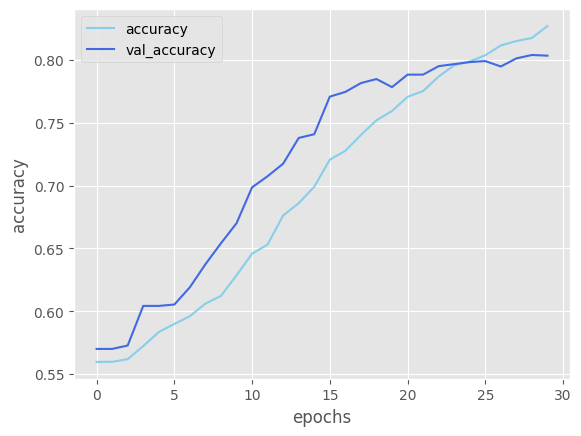

In [ ]:
# visualisation of training and validation accuracy
plt.style.use('ggplot')
plt.plot(history2.history['accuracy'],color='skyblue')
plt.plot(history2.history['val_accuracy'], color='royalblue')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

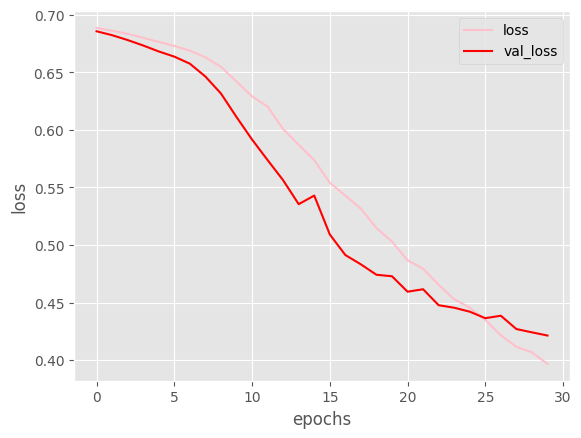

In [ ]:
# visualisation of training and validation loss
plt.plot(history2.history['loss'], color='pink')
plt.plot(history2.history['val_loss'], color='red')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

In [ ]:
# performance score
accuracy = history2.history['val_accuracy'][-1]
recall = history2.history['val_recall_5'][-1]
precision = history2.history['val_precision_5'][-1]
f1score = (2*precision*recall) / (precision+recall)

print("Accuracy: {}".format(accuracy))
print("Recall: {}".format(recall))
print("Precision: {}".format(precision))
print("F1 Score: {}".format(f1score))

Accuracy: 0.8034510612487793
Recall: 0.7065830826759338
Precision: 0.8119596838951111
F1 Score: 0.755615171445806
